In [20]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../utils')

In [21]:
import open3d as o3d
import numpy as np

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch_scatter import scatter_max

import matplotlib.pyplot as plt

import random
import pickle
from tqdm import tqdm

from mean_shift_clustering import mean_shift_clustering, mode_extraction
from models import JointFeatureNet, GMEdgeConv, GMEdgeNet

In [63]:
class RigNetDataset(Dataset):
    def __init__(self, file_path):

        with open(file_path, 'rb') as f:
            self.examples = pickle.load(f)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, index):
        G = self.examples[index]


        G['vertices'] = torch.FloatTensor(G['vertices'])
        G['one_ring'] = torch.LongTensor(G['one_ring'])
        G['geodesic'] = torch.LongTensor(G['geodesic'])
        G['attn_mask'] = torch.FloatTensor(G['attn_mask'])

        return G


In [64]:
# Use val and test sets for testing
train_path = '../data/ModelResource_RigNetv1_preproccessed/mesh_graphs/val.pkl'
val_path = '../data/ModelResource_RigNetv1_preproccessed/mesh_graphs/test.pkl'

In [65]:
train_ds = RigNetDataset(train_path)
val_ds = RigNetDataset(val_path)

In [66]:
def validate(
    model: torch.nn.Module,
    dataset,
    loss_fn: torch.nn.Module,
    device: str = "cpu"
):
    """
    Compute average loss over `dataset` without gradient updates.
    """
    model.eval()
    total_loss = 0.0
    
    with torch.no_grad():
        for i in range(len(dataset)):
            G = dataset[i]
            
            verts = G['vertices']
            one_ring = G['one_ring']
            geodesic = G['geodesic']
            attn_mask = G['attn_mask']
            
            logits = model(verts, one_ring, geodesic).view(-1)
            loss = loss_fn(logits, attn_mask)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(dataset)
    return avg_loss

In [89]:
def train(
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    train_ds,
    val_ds = None,
    epochs: int = 10,
    device: str = "cpu"
):

    model.to(device)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    train_losses = []
    val_losses   = []
    
    for epoch in range(1, epochs+1):
        model.train()
        running_loss = 0.0
        
        for i in tqdm(range(len(train_ds)), desc=f"Epoch {epoch}/{epochs}"):
            G = train_ds[i]
            
            # move data to device
            verts = G['vertices']
            one_ring = G['one_ring']
            geodesic = G['geodesic']
            attn_mask = G['attn_mask']
            
            # forward
            logits = model(verts, one_ring, geodesic)
            logits = logits.view(-1)
            
            loss = loss_fn(logits, attn_mask)
            
            # backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_train = running_loss / len(train_ds)
        train_losses.append(avg_train)
        
        # optional validation
        if val_ds is not None:
            avg_val = validate(model, val_ds, loss_fn, device)
            val_losses.append(avg_val)
            print(f"Epoch {epoch}: train loss = {avg_train:.4e}, val loss = {avg_val:.4e}")

            # plot
            plt.figure()
            plt.semilogy(range(1, epoch+1), train_losses, label="train")
            if val_ds is not None:
                plt.semilogy(range(1, epoch+1), val_losses, label="val")
            plt.xlabel("Epoch")
            plt.ylabel("Loss (BCEWithLogits)")
            plt.title("Attention Head Training Loss")
            plt.legend()
            plt.show()

        else:
            print(f"Epoch {epoch}: train loss = {avg_train:.4e}")
    
    return train_losses, val_losses

In [ ]:
jointnet = JointFeatureNet(is_training=True)
attn_module = jointnet.attn_head

In [100]:
untrained_jointnet = JointNet(is_training=True)
untrained_attn_module = untrained_jointnet.attn_head

### Pre-training Testing

In [101]:
import matplotlib.cm as cm

def visualize_attention_heatmap(verts: np.ndarray,
                                edges: np.ndarray,
                                attn_pred: np.ndarray,
                                attn_gt: np.ndarray = None):

    # create wireframe
    ls = o3d.geometry.LineSet()
    ls.points = o3d.utility.Vector3dVector(verts)
    ls.lines  = o3d.utility.Vector2iVector(edges)
    ls.colors = o3d.utility.Vector3dVector(np.tile([0.7,0.7,0.7], (len(edges),1)))
    
    # map predictions to colors
    N = attn_pred.shape[0]
    rgb = np.zeros((N, 3), dtype=attn_pred.dtype)
    rgb[:, 0] = attn_pred.reshape(-1)
    
    # make a point cloud of vertices colored by pred
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(verts)
    pcd.colors = o3d.utility.Vector3dVector(rgb)
    
    # overlay GT as blue points
    geometries = [ls, pcd]
    if attn_gt is not None:
        gt_idxs = np.nonzero(attn_gt.astype(bool))[0]
        if len(gt_idxs) > 0:
            gt_pcd = o3d.geometry.PointCloud()
            # Index the vertices which have a non-zero mask value
            gt_pcd.points = o3d.utility.Vector3dVector(verts[gt_idxs])
            gt_colors = np.tile([0.0,0.0,1.0], (len(gt_idxs),1))
            gt_pcd.colors = o3d.utility.Vector3dVector(gt_colors)
            geometries.append(gt_pcd)
    
    # render
    o3d.visualization.draw_geometries(
        geometries,
        window_name="Attention Heatmap (mesh+pred+gt)"
    )

In [102]:
G = train_ds[0]
verts = G['vertices']
one_ring = G['one_ring']
geodesic = G['geodesic']
attn_mask = G['attn_mask']

attn_pred = F.sigmoid(untrained_attn_module(verts, one_ring, geodesic))
attn_gt = attn_mask

In [93]:
attn_pred

tensor([[0.5091],
        [0.5091],
        [0.5091],
        ...,
        [0.5094],
        [0.5094],
        [0.5093]], grad_fn=<SigmoidBackward0>)

In [103]:
# Everything is given a ~0.5 probability. 
visualize_attention_heatmap(verts=verts.detach().numpy(), 
                           edges=one_ring.reshape(-1, 2).detach().numpy(), 
                           attn_pred=attn_pred.detach().numpy())

### Training

In [95]:
epochs = 2
lr = 1e-4
wd = 1e-5
optimizer = torch.optim.AdamW(params=attn_module.parameters(), lr=lr, weight_decay=wd)

Epoch 1/2: 100%|██████████| 270/270 [03:48<00:00,  1.18it/s]


Epoch 1: train loss = 6.0019e-01, val loss = 5.7137e-01


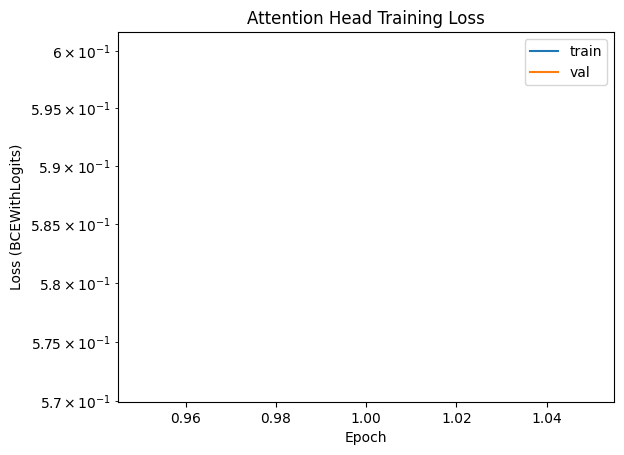

Epoch 2/2: 100%|██████████| 270/270 [09:41<00:00,  2.15s/it]


KeyboardInterrupt: 

In [99]:
train_losses, val_losses = train(
    attn_module, optimizer,
    train_ds=train_ds, val_ds=val_ds,
    epochs=epochs, device="cpu"
)

### Individual Inspection

In [104]:
G = train_ds[0]
verts = G['vertices']
one_ring = G['one_ring']
geodesic = G['geodesic']
attn_mask = G['attn_mask']

attn_pred = F.sigmoid(attn_module(verts, one_ring, geodesic))
attn_gt = attn_mask

attn_pred

tensor([[0.4238],
        [0.4668],
        [0.4660],
        ...,
        [0.2850],
        [0.2838],
        [0.2828]], grad_fn=<SigmoidBackward0>)

In [107]:
visualize_attention_heatmap(verts=verts.detach().numpy(), 
                           edges=one_ring.reshape(-1, 2).detach().numpy(), 
                           attn_pred=attn_pred.detach().numpy())

Unclear if 4-5 epochs just isn't enough, if LR is too high or too low, etc. Need to run some hyperparameter search grids and evaluate with precision, recall, and F1 to see how the model is doing rather than just vibes

- Use matplotlib to create colormap from the attention predictions (use a highly contrasting colormap)